In [181]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [183]:
print('numpy version',np.__version__,'\nxarray version',xr.__version__)

numpy version 1.22.4 
xarray version 2022.12.0


In [184]:
import xgcm
from xgcm import Grid
import xwmt
print('xgcm version',xgcm.__version__)
print('xwmt version',xwmt.__version__)

xgcm version 0.8.1
xwmt version 0.0.3


### Load grids and data

In [218]:
gridname = 'natv' # choose from ['zstr', 'natv', 'rho2']
dt = 'daily' # choose from ['monthly', 'daily', 'hourly']

# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_'
time = "190*"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])

# Select year-long subset
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

#  Load grid
oceangridname = '19000101.ocean_static.nc'
ocean_grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Some renaming of variables to match conventions
ocean_grid = ocean_grid.rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao', 'salt':'so'})
ds['sigma2'] = ds['rhopot2']-1000.

# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "wet": xr.DataArray(ocean_grid["wet"].values, dims=('yh', 'xh',)),
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)),
    "lon": xr.DataArray(ocean_grid["geolon"].values, dims=('yh', 'xh',)),
    "lat": xr.DataArray(ocean_grid["geolat"].values, dims=('yh', 'xh',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'right': 'xq'},
    'Y': {'center': 'yh', 'right': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'}
}
metrics = {
    ('X','Y'): "areacello",
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=None)

# Part 1. A minimal example

### Watermass meta data

`xwmt` requires some basic information about water mass properties to compute WMT.

In [251]:
metadata_dict = {
    "mass": {"lambda": "density", "thickness": "thkcello"},
    "heat": {"lambda": "thetao", "surface_lambda": "tos"},
    "salt": {"lambda": "so", "surface_lambda": "sos"}
}

### Computing WMTs term by term

To evaluate the WMT for a given term, we simply specify what side of the equation the term belongs on (material derivative on the left; non-conservative processes on the right), 
\begin{equation}
\rho \frac{\text{D}\lambda}{\text{D}t} = \dot{\Lambda}
\end{equation}
and provide a dictionary that links each diagnostic variable to a more intuitively named string that describes the process, e.g. `diffusion`.

By default, diagnostic tendencies are assumed to be integrated vertically over each model layer and density-weighted, but not integrated over the grid cell area.

In [258]:
metadata_dict["heat"]["rhs"] = {"diffusion": "opottempdiff"}

We can then create an instance of the core class `xwmt.WaterMassTransformations`, which inherits some useful methods from it's parent class `xwmt.WaterMass`.

In [259]:
wmt = xwmt.WaterMassTransformations(grid, metadata_dict)

The utility method `WaterMassTransformations.available_processes` searches through the budgets in the metadata dictionary to find all of the processes that are available in the underlying instance of `xarray.Dataset` which resides at `grid._ds`.

In [260]:
wmt.available_processes()

['diffusion']

Finally, we can use the `integrate_transformations` method to compute water mass transformations.

In [261]:
tmp = wmt.integrate_transformations("heat", term="diffusion", bins=np.arange(-2., 30, 0.5));

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


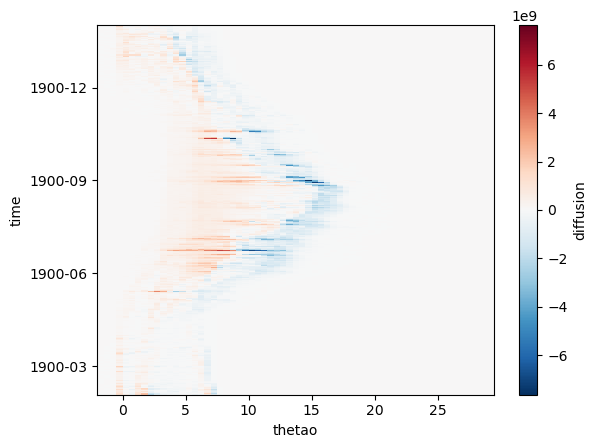

In [263]:
tmp.plot(x="thetao")

From this analysis, we can see that diffusion generally acts to transform colder waters into warmer ones, and warmer waters into colder ones. This matches our intuition that turbulent mixing acts to homogenize water masses.

# Part 2. Closed and comprehensive water mass transformation budgets

### Comprehensive budget dictionary

Using `xbudget`, we can read in a pre-configured dictionary that contains comprehensive metadata about the structure of tracer budgets in MOM6. This dictionary can also be manually created.

In [264]:
import json
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6")
xbudget.collect_budgets(ds, budgets_dict)

print(json.dumps(budgets_dict['heat'], sort_keys=True, indent=4))

{
    "lambda": "thetao",
    "lhs": {
        "sum": {
            "Eulerian_tendency": "opottemptend",
            "advection": {
                "sum": {
                    "interfacial": {
                        "product": {
                            "convergence": "Th_tendency_vert_remap",
                            "sign": -1.0,
                            "var": "heat_lhs_advection_interfacial_product"
                        },
                        "var": "heat_lhs_advection_interfacial_product"
                    },
                    "lateral": {
                        "product": {
                            "convergence": "T_advection_xy",
                            "sign": -1.0,
                            "var": "heat_lhs_advection_lateral_product"
                        },
                        "var": "heat_lhs_advection_lateral_product"
                    },
                    "var": "heat_lhs_advection_sum"
                },
                "var": "he

Note how this nested dictionary structure allows diagnostics, which are technically unavailable in the convenient layer-integrated form of our example above, to be derived from other available variables. For example, consider the advective surface ocean heat flux, which we characterize as

```python
"surface_ocean_flux_advective_negative_rhs": {
                "product": {
                    "density": 1035.0,
                    "lambda_mass": "tos",
                    "sign": -1.0,
                    "specific_heat_capacity": 3992.0,
                    "thickness_tendency": "boundary_forcing_h_tendency",
                    "var": "heat_rhs_surface_ocean_flux_advective_negative_rhs_product"
                },
```

This gives instructions to `xwmt`'s dependency `xbudget` on how to reconstruct the `surface_ocean_flux_advective_negative_rhs` tendency as a product of other terms:
\begin{equation}
-\lambda_{m}Q_{m} = (-1)*(c_{p}*\Theta_{m})*\big(\rho_{0}*\big[\frac{\partial h}{\partial t}\big]^{boundary}\big)
\end{equation}

The full dictionary is fairly daunting and we don't need every term just to close the water mass transformation budget. Let's use the `xbudget.aggregate` function to just pick out the high-level terms.

In [265]:
simple_budgets = xbudget.aggregate(budgets_dict)
print(json.dumps(simple_budgets, sort_keys=True, indent=4))

{
    "heat": {
        "lambda": "thetao",
        "lhs": {
            "Eulerian_tendency": "opottemptend",
            "advection": "heat_lhs_advection_sum",
            "surface_ocean_flux_advective_negative_lhs": "heat_lhs_surface_ocean_flux_advective_negative_lhs_product"
        },
        "rhs": {
            "bottom_flux": "internal_heat_heat_tendency",
            "diffusion": "heat_rhs_diffusion_sum",
            "frazil_ice": "frazil_heat_tendency",
            "surface_exchange_flux": "boundary_forcing_heat_tendency",
            "surface_ocean_flux_advective_negative_rhs": "heat_rhs_surface_ocean_flux_advective_negative_rhs_product"
        },
        "surface_lambda": "tos"
    },
    "mass": {
        "lambda": "density",
        "lhs": {
            "Eulerian_tendency": "mass_lhs_Eulerian_tendency_product"
        },
        "rhs": {
            "advection": "mass_rhs_advection_sum",
            "surface_exchange_flux": "mass_rhs_surface_exchange_flux_product"
        

### Compute water mass transformations

Finally, we can create an instance of the core `WaterMassTransformations` class and verify that it can find all of the processes we need in the dataset.

In [266]:
wmt = xwmt.WaterMassTransformations(grid, simple_budgets)
wmt.available_processes()

['bottom_flux',
 'surface_exchange_flux',
 'surface_ocean_flux_advective_negative_lhs',
 'Eulerian_tendency',
 'frazil_ice',
 'surface_ocean_flux_advective_negative_rhs',
 'advection',
 'diffusion']

**Note:** In addition to information about the static model grid, the attribute `grid._ds` points to the full dataset containing the diagnostics!

In [267]:
grid._ds

<xarray.Dataset>
Dimensions:                                                     (xh: 97,
                                                                 yh: 105,
                                                                 time: 365,
                                                                 nv: 2, zl: 75,
                                                                 zi: 76,
                                                                 xq: 98, yq: 106)
Coordinates:
  * xh                                                          (xh) float64 ...
  * yh                                                          (yh) float64 ...
  * time                                                        (time) object ...
  * nv                                                          (nv) float64 ...
  * zl                                                          (zl) float64 ...
  * zi                                                          (zi) float64 ...
  * xq                                                          (xq) float64 ...
  * yq                                                          (yq) float64 ...
    wet                                                         (yh, xh) float32 ...
    areacello                                                   (yh, xh) float32 ...
    lon                                                         (yh, xh) float32 ...
    lat                                                         (yh, xh) float32 ...
Data variables: (12/92)
    tos                                                         (time, yh, xh) float32 dask.array<chunksize=(9, 105, 97), meta=np.ndarray>
    sos                                                         (time, yh, xh) float32 dask.array<chunksize=(9, 105, 97), meta=np.ndarray>
    hfds                                                        (time, yh, xh) float32 dask.array<chunksize=(9, 105, 97), meta=np.ndarray>
    hflso                                                       (time, yh, xh) float32 dask.array<chunksize=(9, 105, 97), meta=np.ndarray>
    hfsso                                                       (time, yh, xh) float32 dask.array<chunksize=(9, 105, 97), meta=np.ndarray>
    rlntds                                                      (time, yh, xh) float32 dask.array<chunksize=(9, 105, 97), meta=np.ndarray>
    ...                                                          ...
    salt_rhs_diffusion_sum                                      (time, zl, yh, xh) float32 dask.array<chunksize=(9, 75, 105, 97), meta=np.ndarray>
    salt_rhs_surface_exchange_flux_nonadvective_sum             (time, yh, xh) float32 dask.array<chunksize=(9, 105, 97), meta=np.ndarray>
    salt_rhs_surface_exchange_flux_advective_product            (time, zl, yh, xh) float32 dask.array<chunksize=(9, 75, 105, 97), meta=np.ndarray>
    salt_rhs_surface_exchange_flux_sum                          (time, yh, xh, zl) float32 dask.array<chunksize=(9, 105, 97, 75), meta=np.ndarray>
    salt_rhs_surface_ocean_flux_advective_negative_rhs_product  (time, yh, xh, zl) float32 dask.array<chunksize=(9, 105, 97, 75), meta=np.ndarray>
    salt_rhs_sum                                                (time, zl, yh, xh) float32 dask.array<chunksize=(9, 75, 105, 97), meta=np.ndarray>

We use the `integrate_transformations` method to compute area-integrated water mass transformations in the specified coordinate (e.g. `"heat"`).

In [268]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    kwargs = {"sum_components":True, "group_processes":True}
    G_temperature = wmt.integrate_transformations(
        "heat",
        bins=np.arange(-2, 30, 0.25),
        **kwargs
    ).mean('time')
    G_salinity = wmt.integrate_transformations(
        "salt",
        bins=np.arange(0, 50, 0.25),
        **kwargs
    ).mean('time')
    G_density = wmt.integrate_transformations(
        "sigma2",
        bins=np.arange(10, 40, 0.25),
        **kwargs
    ).mean('time')
    
Gs = [G_temperature, G_salinity, G_density]

Process 'bottom_flux' for component salt is unavailable.
Process 'frazil_ice' for component salt is unavailable.


In [269]:
for G in Gs:
    G.load()

Finally, we can plot the WMT associated with each of the terms and verify that our water mass transformation budgets close:

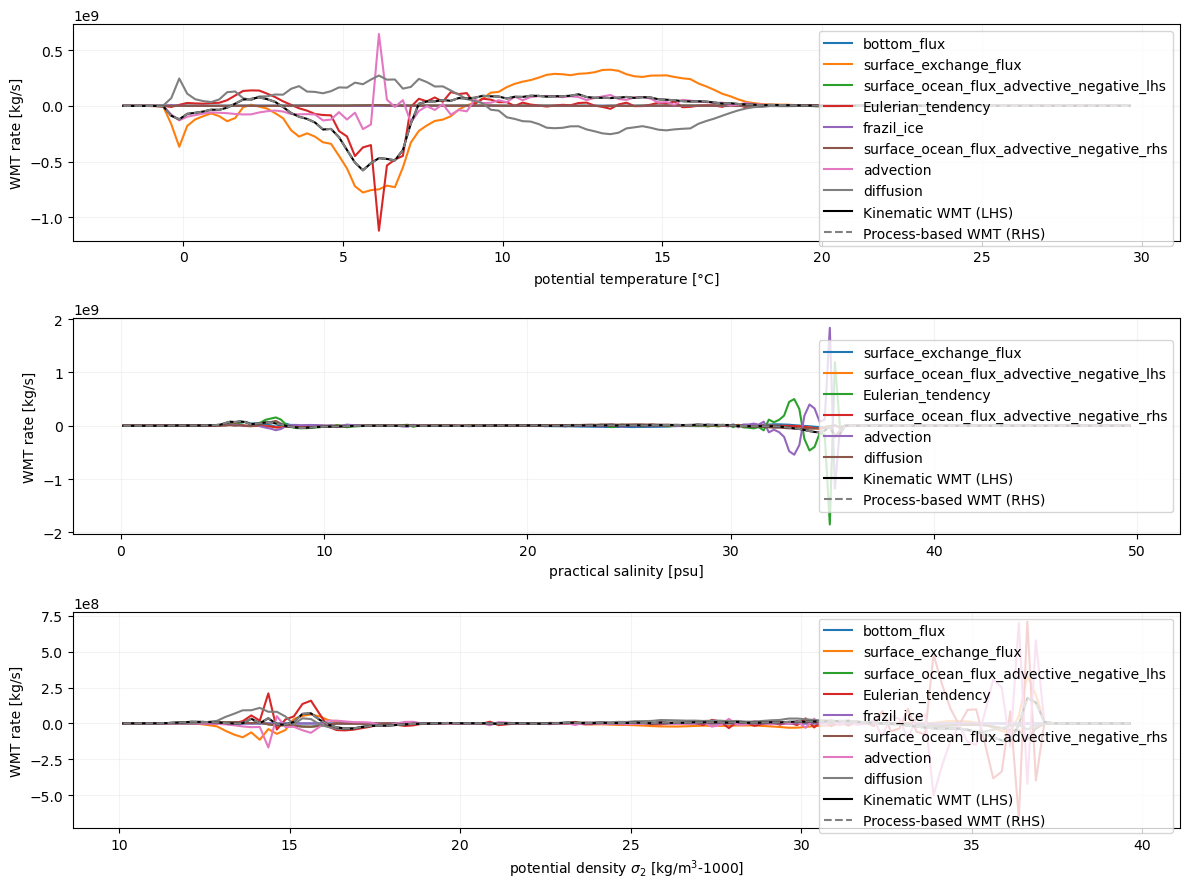

In [270]:
long_names =  [r"potential temperature [$\degree$C]", r"practical salinity [psu]", r"potential density $\sigma_{2}$ [kg/m$^{3}$-1000]"]

plt.figure(figsize=(12, 9))
for i, (G, long_name) in enumerate(zip(Gs, long_names)):
    plt.subplot(3,1,i+1)
    for v in wmt.available_processes():
        if v not in G: continue
        G[v].plot(label=v)
    G['kinematic_material_derivative'].plot(label="Kinematic WMT (LHS)", color="k")
    G['process_material_derivative'].plot(label="Process-based WMT (RHS)", ls="--", color="grey")
    plt.legend()
    plt.ylabel("WMT rate [kg/s]")
    plt.xlabel(long_name)
    plt.grid(True, alpha=0.15)
plt.tight_layout()

# Part 3. Selectively decomposing budget terms

In density coordinates, there seems to be a dominant balance between diffusion and surface fluxes. Let's break those processes down even further to gain a better understanding.

In [271]:
decomposed_budgets = xbudget.aggregate(budgets_dict, decompose=["diffusion", "surface_exchange_flux", "nonadvective"])
wmt = xwmt.WaterMassTransformations(grid, decomposed_budgets)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    G_density = wmt.integrate_transformations(
        "sigma2",
        bins=np.arange(10, 40, 0.25),
        **kwargs
    ).mean('time')
    G_density.load()

In [272]:
decomposed_budgets

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'transport': {'X': 'umo', 'Y': 'vmo'},
  'lhs': {'Eulerian_tendency': 'mass_lhs_Eulerian_tendency_product'},
  'rhs': {'advection': 'mass_rhs_advection_sum',
   'surface_exchange_flux_rain_and_ice': 'prlq',
   'surface_exchange_flux_snow': 'prsn',
   'surface_exchange_flux_evaporation': 'evs',
   'surface_exchange_flux_rivers': 'friver',
   'surface_exchange_flux_icebergs': 'ficeberg',
   'surface_exchange_flux_virtual_precip_restoring': 'vprec'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'opottemptend',
   'advection': 'heat_lhs_advection_sum',
   'surface_ocean_flux_advective_negative_lhs': 'heat_lhs_surface_ocean_flux_advective_negative_lhs_product'},
  'rhs': {'diffusion_lateral': 'opottemppmdiff',
   'diffusion_interfacial': 'opottempdiff',
   'surface_exchange_flux_nonadvective_latent': 'hflso',
   'surface_exchange_flux_nonadvective_sensible': 'hfsso',
   'surface_exchange_

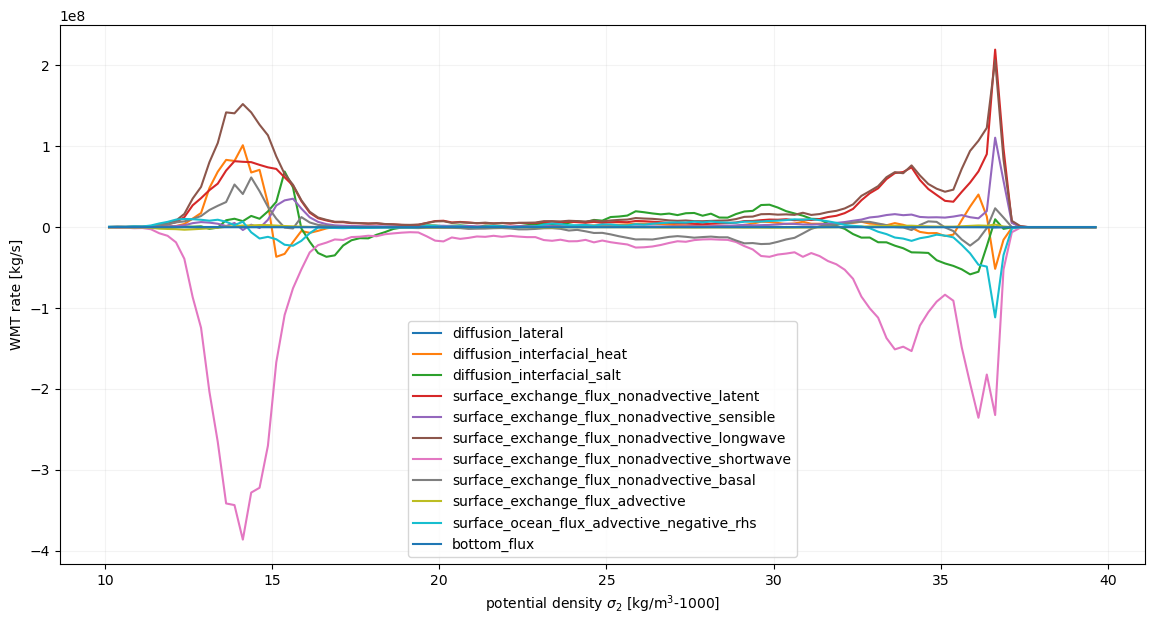

In [273]:
G = G_density
long_name = r"potential density $\sigma_{2}$ [kg/m$^{3}$-1000]"

processes = [
    "diffusion_lateral",
    "diffusion_interfacial_heat",
    "diffusion_interfacial_salt",
    "surface_exchange_flux_nonadvective_latent",
    "surface_exchange_flux_nonadvective_sensible",
    "surface_exchange_flux_nonadvective_longwave",
    "surface_exchange_flux_nonadvective_shortwave",
    "surface_exchange_flux_nonadvective_basal",
    "surface_exchange_flux_advective",
    "surface_ocean_flux_advective_negative_rhs",
    "frazil_heat_tendency",
    "bottom_flux",
]

plt.figure(figsize=(14, 7))
for v in processes:
    if v not in G: continue
    G[v].plot(label=v)
plt.legend()
plt.ylabel("WMT rate [kg/s]")
plt.xlabel(long_name)
plt.grid(True, alpha=0.15)